*아래 링크를 통해 이 노트북을 주피터 노트북 뷰어(nbviewer.jupyter.org)로 보거나 구글 코랩(colab.research.google.com)에서 실행할 수 있습니다.*

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://nbviewer.jupyter.org/github/rickiepark/nlp-with-pytorch/blob/master/chapter_8/8_5_NMT/8_5_NMT_scheduled_sampling.ipynb"><img src="https://jupyter.org/assets/main-logo.svg" width="28" />주피터 노트북 뷰어로 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/nlp-with-pytorch/blob/master/chapter_8/8_5_NMT/8_5_NMT_scheduled_sampling.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
</table>

In [1]:
import os
from argparse import Namespace
from collections import Counter
import json
import re
import string

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook

### Vocabulary

In [2]:
class Vocabulary(object):
    """매핑을 위해 텍스트를 처리하고 어휘 사전을 만드는 클래스 """

    def __init__(self, token_to_idx=None):
        """
        매개변수:
            token_to_idx (dict): 기존 토큰-인덱스 매핑 딕셔너리
        """

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
    def to_serializable(self):
        """ 직렬화할 수 있는 딕셔너리를 반환합니다 """
        return {'token_to_idx': self._token_to_idx}

    @classmethod
    def from_serializable(cls, contents):
        """ 직렬화된 딕셔너리에서 Vocabulary 객체를 만듭니다 """
        return cls(**contents)

    def add_token(self, token):
        """ 토큰을 기반으로 매핑 딕셔너리를 업데이트합니다

        매개변수:
            token (str): Vocabulary에 추가할 토큰
        반환값:
            index (int): 토큰에 상응하는 정수
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
            
    def add_many(self, tokens):
        """토큰 리스트를 Vocabulary에 추가합니다.
        
        매개변수:
            tokens (list): 문자열 토큰 리스트
        반환값:
            indices (list): 토큰 리스트에 상응되는 인덱스 리스트
        """
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        """토큰에 대응하는 인덱스를 추출합니다.
        
        매개변수:
            token (str): 찾을 토큰 
        반환값:
            index (int): 토큰에 해당하는 인덱스
        """
        return self._token_to_idx[token]

    def lookup_index(self, index):
        """ 인덱스에 해당하는 토큰을 반환합니다.
        
        매개변수: 
            index (int): 찾을 인덱스
        반환값:
            token (str): 인텍스에 해당하는 토큰
        에러:
            KeyError: 인덱스가 Vocabulary에 없을 때 발생합니다.
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [3]:
class SequenceVocabulary(Vocabulary):
    def __init__(self, token_to_idx=None, unk_token="<UNK>",
                 mask_token="<MASK>", begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(SequenceVocabulary, self).__init__(token_to_idx)

        self._mask_token = mask_token
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = self.add_token(self._unk_token)
        self.begin_seq_index = self.add_token(self._begin_seq_token)
        self.end_seq_index = self.add_token(self._end_seq_token)

    def to_serializable(self):
        contents = super(SequenceVocabulary, self).to_serializable()
        contents.update({'unk_token': self._unk_token,
                         'mask_token': self._mask_token,
                         'begin_seq_token': self._begin_seq_token,
                         'end_seq_token': self._end_seq_token})
        return contents

    def lookup_token(self, token):
        """ 토큰에 대응하는 인덱스를 추출합니다.
        토큰이 없으면 UNK 인덱스를 반환합니다.
        
        매개변수:
            token (str): 찾을 토큰 
        반환값:
            index (int): 토큰에 해당하는 인덱스
        노트:
            UNK 토큰을 사용하려면 (Vocabulary에 추가하기 위해)
            `unk_index`가 0보다 커야 합니다.
        """
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

### Vectorizer

In [4]:
class NMTVectorizer(object):
    """ 어휘 사전을 생성하고 관리합니다 """
    def __init__(self, source_vocab, target_vocab, max_source_length, max_target_length):
        """
        매개변수:
            source_vocab (SequenceVocabulary): 소스 단어를 정수에 매핑합니다
            target_vocab (SequenceVocabulary): 타깃 단어를 정수에 매핑합니다
            max_source_length (int): 소스 데이터셋에서 가장 긴 시퀀스 길이
            max_target_length (int): 타깃 데이터셋에서 가장 긴 시퀀스 길이
        """
        self.source_vocab = source_vocab
        self.target_vocab = target_vocab
        
        self.max_source_length = max_source_length
        self.max_target_length = max_target_length
        

    def _vectorize(self, indices, vector_length=-1, mask_index=0):
        """인덱스를 벡터로 변환합니다
        
        매개변수:
            indices (list): 시퀀스를 나타내는 정수 리스트
            vector_length (int): 인덱스 벡터의 길이
            mask_index (int): 사용할 마스크 인덱스; 거의 항상 0
        """
        if vector_length < 0:
            vector_length = len(indices)
        
        vector = np.zeros(vector_length, dtype=np.int64)
        vector[:len(indices)] = indices
        vector[len(indices):] = mask_index

        return vector
    
    def _get_source_indices(self, text):
        """ 벡터로 변환된 소스 텍스트를 반환합니다
        
        매개변수:
            text (str): 소스 텍스트; 토큰은 공백으로 구분되어야 합니다
        반환값:
            indices (list): 텍스트를 표현하는 정수 리스트
        """
        indices = [self.source_vocab.begin_seq_index]
        indices.extend(self.source_vocab.lookup_token(token) for token in text.split(" "))
        indices.append(self.source_vocab.end_seq_index)
        return indices
    
    def _get_target_indices(self, text):
        """ 벡터로 변환된 타깃 텍스트를 반환합니다
        
        매개변수:
            text (str): 타깃 텍스트; 토큰은 공백으로 구분되어야 합니다
        반환값:
            튜플: (x_indices, y_indices)
                x_indices (list): 디코더에서 샘플을 나타내는 정수 리스트
                y_indices (list): 디코더에서 예측을 나타내는 정수 리스트
        """
        indices = [self.target_vocab.lookup_token(token) for token in text.split(" ")]
        x_indices = [self.target_vocab.begin_seq_index] + indices
        y_indices = indices + [self.target_vocab.end_seq_index]
        return x_indices, y_indices
        
    def vectorize(self, source_text, target_text, use_dataset_max_lengths=True):
        """ 벡터화된 소스 텍스트와 타깃 텍스트를 반환합니다
        
        벡터화된 소스 텍슽트는 하나의 벡터입니다.
        벡터화된 타깃 텍스트는 7장의 성씨 모델링과 비슷한 스타일로 두 개의 벡터로 나뉩니다.
        각 타임 스텝에서 첫 번째 벡터가 샘플이고 두 번째 벡터가 타깃이 됩니다.
                
        매개변수:
            source_text (str): 소스 언어의 텍스트
            target_text (str): 타깃 언어의 텍스트
            use_dataset_max_lengths (bool): 최대 벡터 길이를 사용할지 여부
        반환값:
            다음과 같은 키에 벡터화된 데이터를 담은 딕셔너리: 
                source_vector, target_x_vector, target_y_vector, source_length
        """
        source_vector_length = -1
        target_vector_length = -1
        
        if use_dataset_max_lengths:
            source_vector_length = self.max_source_length + 2
            target_vector_length = self.max_target_length + 1
            
        source_indices = self._get_source_indices(source_text)
        source_vector = self._vectorize(source_indices, 
                                        vector_length=source_vector_length, 
                                        mask_index=self.source_vocab.mask_index)
        
        target_x_indices, target_y_indices = self._get_target_indices(target_text)
        target_x_vector = self._vectorize(target_x_indices,
                                        vector_length=target_vector_length,
                                        mask_index=self.target_vocab.mask_index)
        target_y_vector = self._vectorize(target_y_indices,
                                        vector_length=target_vector_length,
                                        mask_index=self.target_vocab.mask_index)
        return {"source_vector": source_vector, 
                "target_x_vector": target_x_vector, 
                "target_y_vector": target_y_vector, 
                "source_length": len(source_indices)}
        
    @classmethod
    def from_dataframe(cls, bitext_df):
        """ 데이터셋 데이터프레임으로 NMTVectorizer를 초기화합니다
        
        매개변수:
            bitext_df (pandas.DataFrame): 텍스트 데이터셋
        반환값
        :
            NMTVectorizer 객체
        """
        source_vocab = SequenceVocabulary()
        target_vocab = SequenceVocabulary()
        
        max_source_length = 0
        max_target_length = 0

        for _, row in bitext_df.iterrows():
            source_tokens = row["source_language"].split(" ")
            if len(source_tokens) > max_source_length:
                max_source_length = len(source_tokens)
            for token in source_tokens:
                source_vocab.add_token(token)
            
            target_tokens = row["target_language"].split(" ")
            if len(target_tokens) > max_target_length:
                max_target_length = len(target_tokens)
            for token in target_tokens:
                target_vocab.add_token(token)
            
        return cls(source_vocab, target_vocab, max_source_length, max_target_length)

    @classmethod
    def from_serializable(cls, contents):
        source_vocab = SequenceVocabulary.from_serializable(contents["source_vocab"])
        target_vocab = SequenceVocabulary.from_serializable(contents["target_vocab"])
        
        return cls(source_vocab=source_vocab, 
                   target_vocab=target_vocab, 
                   max_source_length=contents["max_source_length"], 
                   max_target_length=contents["max_target_length"])

    def to_serializable(self):
        return {"source_vocab": self.source_vocab.to_serializable(), 
                "target_vocab": self.target_vocab.to_serializable(), 
                "max_source_length": self.max_source_length,
                "max_target_length": self.max_target_length}

### Dataset

In [5]:
class NMTDataset(Dataset):
    def __init__(self, text_df, vectorizer):
        """
        매개변수:
            text_df (pandas.DataFrame): 데이터셋
            vectorizer (SurnameVectorizer): 데이터셋에서 만든 Vectorizer 객체
        """
        self.text_df = text_df
        self._vectorizer = vectorizer

        self.train_df = self.text_df[self.text_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.text_df[self.text_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.text_df[self.text_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

    @classmethod
    def load_dataset_and_make_vectorizer(cls, dataset_csv):
        """데이터셋을 로드하고 새로운 Vectorizer를 만듭니다
        
        매개변수:
            dataset_csv (str): 데이터셋의 위치
        반환값:
            NMTDataset의 객체
        """
        text_df = pd.read_csv(dataset_csv)
        train_subset = text_df[text_df.split=='train']
        return cls(text_df, NMTVectorizer.from_dataframe(train_subset))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, dataset_csv, vectorizer_filepath):
        """데이터셋과 새로운 Vectorizer 객체를 로드합니다.
        캐싱된 Vectorizer 객체를 재사용할 때 사용합니다.
        
        매개변수:
            dataset_csv (str): 데이터셋의 위치
            vectorizer_filepath (str): Vectorizer 객체의 저장 위치
        반환값:
            NMTDataset의 객체
        """
        text_df = pd.read_csv(dataset_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(text_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        """파일에서 Vectorizer 객체를 로드하는 정적 메서드
        
        매개변수:
            vectorizer_filepath (str): 직렬화된 Vectorizer 객체의 위치
        반환값:
            NMTVectorizer의 인스턴스
        """
        with open(vectorizer_filepath) as fp:
            return NMTVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        """Vectorizer 객체를 json 형태로 디스크에 저장합니다
        
        매개변수:
            vectorizer_filepath (str): Vectorizer 객체의 저장 위치
        """
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        """ 벡터 변환 객체를 반환합니다 """
        return self._vectorizer

    def set_split(self, split="train"):
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        """파이토치 데이터셋의 주요 진입 메서드
        
        매개변수:
            index (int): 데이터 포인트에 대한 인덱스 
        반환값:
            데이터 포인트(x_source, x_target, y_target, x_source_length)를 담고 있는 딕셔너리
        """
        row = self._target_df.iloc[index]

        vector_dict = self._vectorizer.vectorize(row.source_language, row.target_language)

        return {"x_source": vector_dict["source_vector"], 
                "x_target": vector_dict["target_x_vector"],
                "y_target": vector_dict["target_y_vector"], 
                "x_source_length": vector_dict["source_length"]}
        
    def get_num_batches(self, batch_size):
        """배치 크기가 주어지면 데이터셋으로 만들 수 있는 배치 개수를 반환합니다
        
        매개변수:
            batch_size (int)
        반환값:
            배치 개수
        """
        return len(self) // batch_size

In [ ]:
def generate_nmt_batches(dataset, batch_size, shuffle=True, 
                            drop_last=True, device="cpu"):
    """ 파이토치 DataLoader를 감싸고 있는 제너레이터 함수; NMT 버전 """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        lengths = data_dict['x_source_length'].numpy()
        sorted_length_indices = lengths.argsort()[::-1].tolist()
        
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name][sorted_length_indices].to(device)
        yield out_data_dict

## 신경망 기계 번역 모델

구성 요소:

1. NMTEncoder
    - 소스 시퀀스를 입력으로 받아 임베딩하여 양방향 GRU에 주입합니다.
2. NMTDecoder
    - 인코더 상태와 어텐션을 사용해 디코더가 새로운 시퀀스를 생성합니다.
    - 타임 스텝마다 정답 타깃 시퀀스를 입력으로 사용합니다.
    - 또는 디코더가 선택한 시퀀스를 입력으로 사용할 수도 있습니다.
    - 이를 커리큘럼 학습(curriculum learning), 탐색 학습(learning to search)이라 부릅니다.
3. NMTModel
    - 인코더와 디코더를 하나의 클래스로 구성합니다.

In [6]:
class NMTEncoder(nn.Module):
    def __init__(self, num_embeddings, embedding_size, rnn_hidden_size):
        """
        매개변수:
            num_embeddings (int): 임베딩 개수는 소스 어휘 사전의 크기입니다
            embedding_size (int): 임베딩 벡터의 크기
            rnn_hidden_size (int): RNN 은닉 상태 벡터의 크기
        """
        super(NMTEncoder, self).__init__()
    
        self.source_embedding = nn.Embedding(num_embeddings, embedding_size, padding_idx=0)
        self.birnn = nn.GRU(embedding_size, rnn_hidden_size, bidirectional=True, batch_first=True)
    
    def forward(self, x_source, x_lengths):
        """ 모델의 정방향 계산
        
        매개변수:
            x_source (torch.Tensor): 입력 데이터 텐서
                x_source.shape는 (batch, seq_size)이다.
            x_lengths (torch.Tensor): 배치에 있는 아이템의 길이 벡터
        반환값:
            튜플: x_unpacked (torch.Tensor), x_birnn_h (torch.Tensor)
                x_unpacked.shape = (batch, seq_size, rnn_hidden_size * 2)
                x_birnn_h.shape = (batch, rnn_hidden_size * 2)
        """
        x_embedded = self.source_embedding(x_source)
        # PackedSequence 생성; x_packed.data.shape=(number_items, embeddign_size)
        x_packed = pack_padded_sequence(x_embedded, x_lengths.detach().cpu().numpy(), 
                                        batch_first=True)
        
        # x_birnn_h.shape = (num_rnn, batch_size, feature_size)
        x_birnn_out, x_birnn_h  = self.birnn(x_packed)
        # (batch_size, num_rnn, feature_size)로 변환
        x_birnn_h = x_birnn_h.permute(1, 0, 2)
        
        # 특성 펼침; (batch_size, num_rnn * feature_size)로 바꾸기
        # (참고: -1은 남은 차원에 해당합니다, 
        #       두 개의 RNN 은닉 벡터를 1로 펼칩니다)
        x_birnn_h = x_birnn_h.contiguous().view(x_birnn_h.size(0), -1)
        
        x_unpacked, _ = pad_packed_sequence(x_birnn_out, batch_first=True)
        
        return x_unpacked, x_birnn_h

def verbose_attention(encoder_state_vectors, query_vector):
    """ 원소별 연산을 사용하는 어텐션 메커니즘 버전
    
    매개변수:
        encoder_state_vectors (torch.Tensor): 인코더의 양방향 GRU에서 출력된 3차원 텐서
        query_vector (torch.Tensor): 디코더 GRU의 은닉 상태
    """
    batch_size, num_vectors, vector_size = encoder_state_vectors.size()
    vector_scores = torch.sum(encoder_state_vectors * query_vector.view(batch_size, 1, vector_size), 
                              dim=2)
    vector_probabilities = F.softmax(vector_scores, dim=1)
    weighted_vectors = encoder_state_vectors * vector_probabilities.view(batch_size, num_vectors, 1)
    context_vectors = torch.sum(weighted_vectors, dim=1)
    return context_vectors, vector_probabilities, vector_scores

def terse_attention(encoder_state_vectors, query_vector):
    """ 점곱을 사용하는 어텐션 메커니즘 버전
    
    매개변수:
        encoder_state_vectors (torch.Tensor): 인코더의 양방향 GRU에서 출력된 3차원 텐서
        query_vector (torch.Tensor): 디코더 GRU의 은닉 상태
    """
    vector_scores = torch.matmul(encoder_state_vectors, query_vector.unsqueeze(dim=2)).squeeze()
    vector_probabilities = F.softmax(vector_scores, dim=-1)
    context_vectors = torch.matmul(encoder_state_vectors.transpose(-2, -1), 
                                   vector_probabilities.unsqueeze(dim=2)).squeeze()
    return context_vectors, vector_probabilities



class NMTDecoder(nn.Module):
    def __init__(self, num_embeddings, embedding_size, rnn_hidden_size, bos_index):
        """
        매개변수:
            num_embeddings (int): 임베딩 개수는 타깃 어휘 사전에 있는 고유한 단어의 개수이다
            embedding_size (int): 임베딩 벡터 크기
            rnn_hidden_size (int): RNN 은닉 상태 크기
            bos_index(int): begin-of-sequence 인덱스
        """
        super(NMTDecoder, self).__init__()
        self._rnn_hidden_size = rnn_hidden_size
        self.target_embedding = nn.Embedding(num_embeddings=num_embeddings, 
                                             embedding_dim=embedding_size, 
                                             padding_idx=0)
        self.gru_cell = nn.GRUCell(embedding_size + rnn_hidden_size, 
                                   rnn_hidden_size)
        self.hidden_map = nn.Linear(rnn_hidden_size, rnn_hidden_size)
        self.classifier = nn.Linear(rnn_hidden_size * 2, num_embeddings)
        self.bos_index = bos_index
        self._sampling_temperature = 3
    
    def _init_indices(self, batch_size):
        """ BEGIN-OF-SEQUENCE 인덱스 벡터를 반환합니다 """
        return torch.ones(batch_size, dtype=torch.int64) * self.bos_index
    
    def _init_context_vectors(self, batch_size):
        """ 문맥 벡터를 초기화하기 위한 0 벡터를 반환합니다 """
        return torch.zeros(batch_size, self._rnn_hidden_size)
            
    def forward(self, encoder_state, initial_hidden_state, target_sequence, sample_probability=0.0):
        """ 모델의 정방향 계산
        
        매개변수:
            encoder_state (torch.Tensor): NMTEncoder의 출력
            initial_hidden_state (torch.Tensor): NMTEncoder의 마지막 은닉 상태
            target_sequence (torch.Tensor): 타깃 텍스트 데이터 텐서
            sample_probability (float): 스케줄링된 샘플링 파라미터
                디코더 타임 스텝마다 모델 예측에 사용할 확률
        반환값:
            output_vectors (torch.Tensor): 각 타임 스텝의 예측 벡터
        """
        if target_sequence is None:
            sample_probability = 1.0
        else:
            # 가정: 첫 번째 차원은 배치 차원입니다
            # 즉 입력은 (Batch, Seq)
            # 시퀀스에 대해 반복해야 하므로 (Seq, Batch)로 차원을 바꿉니다
            target_sequence = target_sequence.permute(1, 0)
            output_sequence_size = target_sequence.size(0)
        
        # 주어진 인코더의 은닉 상태를 초기 은닉 상태로 사용합니다
        h_t = self.hidden_map(initial_hidden_state)
        
        batch_size = encoder_state.size(0)
        # 문맥 벡터를 0으로 초기화합니다
        context_vectors = self._init_context_vectors(batch_size)
        # 첫 단어 y_t를 BOS로 초기화합니다
        y_t_index = self._init_indices(batch_size)
        
        h_t = h_t.to(encoder_state.device)
        y_t_index = y_t_index.to(encoder_state.device)
        context_vectors = context_vectors.to(encoder_state.device)

        output_vectors = []
        self._cached_p_attn = []
        self._cached_ht = []
        self._cached_decoder_state = encoder_state.cpu().detach().numpy()
        
        for i in range(output_sequence_size):
            # 스케줄링된 샘플링 사용 여부
            use_sample = np.random.random() < sample_probability
            if not use_sample:
                y_t_index = target_sequence[i]
                
            # 단계 1: 단어를 임베딩하고 이전 문맥과 연결합니다
            y_input_vector = self.target_embedding(y_t_index)
            rnn_input = torch.cat([y_input_vector, context_vectors], dim=1)
            
            # 단계 2: GRU를 적용하고 새로운 은닉 벡터를 얻습니다
            h_t = self.gru_cell(rnn_input, h_t)
            self._cached_ht.append(h_t.cpu().detach().numpy())
            
            # 단계 3: 현재 은닉 상태를 사용해 인코더의 상태를 주목합니다
            context_vectors, p_attn, _ = verbose_attention(encoder_state_vectors=encoder_state, 
                                                           query_vector=h_t)
            
            # 부가 작업: 시각화를 위해 어텐션 확률을 저장합니다
            self._cached_p_attn.append(p_attn.cpu().detach().numpy())
            
            # 단게 4: 현재 은닉 상태와 문맥 벡터를 사용해 다음 단어를 예측합니다
            prediction_vector = torch.cat((context_vectors, h_t), dim=1)
            score_for_y_t_index = self.classifier(F.dropout(prediction_vector, 0.3))
            
            if use_sample:
                p_y_t_index = F.softmax(score_for_y_t_index * self._sampling_temperature, dim=1)
                # _, y_t_index = torch.max(p_y_t_index, 1)
                y_t_index = torch.multinomial(p_y_t_index, 1).squeeze()
            
            # 부가 작업: 예측 성능 점수를 기록합니다
            output_vectors.append(score_for_y_t_index)
            
        output_vectors = torch.stack(output_vectors).permute(1, 0, 2)
        
        return output_vectors
    
    
class NMTModel(nn.Module):
    """ 신경망 기계 번역 모델 """
    def __init__(self, source_vocab_size, source_embedding_size, 
                 target_vocab_size, target_embedding_size, encoding_size, 
                 target_bos_index):
        """
        매개변수:
            source_vocab_size (int): 소스 언어에 있는 고유한 단어 개수
            source_embedding_size (int): 소스 임베딩 벡터의 크기
            target_vocab_size (int): 타깃 언어에 있는 고유한 단어 개수
            target_embedding_size (int): 타깃 임베딩 벡터의 크기
            encoding_size (int): 인코더 RNN의 크기
            target_bos_index (int): BEGIN-OF-SEQUENCE 토큰 인덱스
        """
        super(NMTModel, self).__init__()
        self.encoder = NMTEncoder(num_embeddings=source_vocab_size, 
                                  embedding_size=source_embedding_size,
                                  rnn_hidden_size=encoding_size)
        decoding_size = encoding_size * 2
        self.decoder = NMTDecoder(num_embeddings=target_vocab_size, 
                                  embedding_size=target_embedding_size, 
                                  rnn_hidden_size=decoding_size,
                                  bos_index=target_bos_index)
    
    def forward(self, x_source, x_source_lengths, target_sequence, sample_probability=0.0):
        """ 모델의 정방향 계산
        
        매개변수:
            x_source (torch.Tensor): 소스 텍스트 데이터 텐서
                x_source.shape는 (batch, vectorizer.max_source_length)입니다.
            x_source_lengths torch.Tensor): x_source에 있는 시퀀스 길이
            target_sequence (torch.Tensor): 타깃 텍스트 데이터 텐서
            sample_probability (float): 스케줄링된 샘플링 파라미터
                디코더 타임 스텝마다 모델 예측에 사용할 확률
        반환값:
            decoded_states (torch.Tensor): 각 출력 타임 스텝의 예측 벡터
        """
        encoder_state, final_hidden_states = self.encoder(x_source, x_source_lengths)
        decoded_states = self.decoder(encoder_state=encoder_state, 
                                      initial_hidden_state=final_hidden_states, 
                                      target_sequence=target_sequence, 
                                      sample_probability=sample_probability)
        return decoded_states

## 모델 훈련과 상태 기록 함수

In [7]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    """훈련 상태 업데이트합니다.
    
    콤포넌트:
     - 조기 종료: 과대 적합 방지
     - 모델 체크포인트: 더 나은 모델을 저장합니다

    :param args: 메인 매개변수
    :param model: 훈련할 모델
    :param train_state: 훈련 상태를 담은 딕셔너리
    :returns:
        새로운 훈련 상태
    """

    # 적어도 한 번 모델을 저장합니다
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # 성능이 향상되면 모델을 저장합니다
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]
         
        # 손실이 나빠지면
        if loss_t >= loss_tm1:
            # 조기 종료 단계 업데이트
            train_state['early_stopping_step'] += 1
        # 손실이 감소하면
        else:
            # 최상의 모델 저장
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t

            # 조기 종료 단계 재설정
            train_state['early_stopping_step'] = 0

        # 조기 종료 여부 확인
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def normalize_sizes(y_pred, y_true):
    """텐서 크기 정규화
    
    매개변수:
        y_pred (torch.Tensor): 모델의 출력
            3차원 텐서이면 행렬로 변환합니다.
        y_true (torch.Tensor): 타깃 예측
            행렬이면 벡터로 변환합니다.
    """
    if len(y_pred.size()) == 3:
        y_pred = y_pred.contiguous().view(-1, y_pred.size(2))
    if len(y_true.size()) == 2:
        y_true = y_true.contiguous().view(-1)
    return y_pred, y_true

def compute_accuracy(y_pred, y_true, mask_index):
    y_pred, y_true = normalize_sizes(y_pred, y_true)

    _, y_pred_indices = y_pred.max(dim=1)
    
    correct_indices = torch.eq(y_pred_indices, y_true).float()
    valid_indices = torch.ne(y_true, mask_index).float()
    
    n_correct = (correct_indices * valid_indices).sum().item()
    n_valid = valid_indices.sum().item()

    return n_correct / n_valid * 100

def sequence_loss(y_pred, y_true, mask_index):
    y_pred, y_true = normalize_sizes(y_pred, y_true)
    return F.cross_entropy(y_pred, y_true, ignore_index=mask_index)

### 설정

In [8]:
args = Namespace(dataset_csv="data/nmt/simplest_eng_fra.csv",
                 vectorizer_file="vectorizer.json",
                 model_state_file="model.pth",
                 save_dir="model_storage/ch8/nmt_luong_sampling",
                 reload_from_files=False,
                 expand_filepaths_to_save_dir=True,
                 cuda=True,
                 seed=1337,
                 learning_rate=5e-4,
                 batch_size=32,
                 num_epochs=100,
                 early_stopping_criteria=5,              
                 source_embedding_size=24, 
                 target_embedding_size=24,
                 encoding_size=32,
                 catch_keyboard_interrupt=True)

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("파일 경로: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
# CUDA 체크
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("CUDA 사용 여부: {}".format(args.cuda))

# 재현성을 위해 시드 설정
set_seed_everywhere(args.seed, args.cuda)

# 디렉토리 처리
handle_dirs(args.save_dir)

Expanded filepaths: 
	model_storage/ch8/nmt_luong_sampling/vectorizer.json
	model_storage/ch8/nmt_luong_sampling/model.pth
Using CUDA: True


In [ ]:
# 만약 코랩에서 실행하는 경우 아래 코드를 실행하여 전처리된 데이터를 다운로드하세요.
!mkdir data
!wget https://git.io/JqQBE -O data/download.py
!wget https://git.io/JqQB7 -O data/get-all-data.sh
!chmod 755 data/get-all-data.sh
%cd data
!./get-all-data.sh
%cd ..

In [9]:
if args.reload_from_files and os.path.exists(args.vectorizer_file):
    # 체크포인트를 로드합니다.
    dataset = NMTDataset.load_dataset_and_load_vectorizer(args.dataset_csv,
                                                          args.vectorizer_file)
else:
    # 데이터셋과 Vectorizer를 만듭니다.
    dataset = NMTDataset.load_dataset_and_make_vectorizer(args.dataset_csv)
    dataset.save_vectorizer(args.vectorizer_file)

vectorizer = dataset.get_vectorizer()

In [10]:
model = NMTModel(source_vocab_size=len(vectorizer.source_vocab), 
                 source_embedding_size=args.source_embedding_size, 
                 target_vocab_size=len(vectorizer.target_vocab),
                 target_embedding_size=args.target_embedding_size, 
                 encoding_size=args.encoding_size,
                 target_bos_index=vectorizer.target_vocab.begin_seq_index)

if args.reload_from_files and os.path.exists(args.model_state_file):
    model.load_state_dict(torch.load(args.model_state_file))
    print("로드한 모델")
else:
    print("새로운 모델")

New model


### 모델 훈련

In [11]:
model = model.to(args.device)

optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)
mask_index = vectorizer.target_vocab.mask_index
train_state = make_train_state(args)

epoch_bar = tqdm_notebook(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm_notebook(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = tqdm_notebook(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

try:
    for epoch_index in range(args.num_epochs):
        sample_probability = (20 + epoch_index) / args.num_epochs
        
        train_state['epoch_index'] = epoch_index

        # 훈련 세트에 대한 순회

        # 훈련 세트와 배치 제너레이터 준비, 손실과 정확도를 0으로 설정
        dataset.set_split('train')
        batch_generator = generate_nmt_batches(dataset, 
                                               batch_size=args.batch_size, 
                                               device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        model.train()
        
        for batch_index, batch_dict in enumerate(batch_generator):
            # 훈련 과정은 5단계로 이루어집니다

            # --------------------------------------
            # 단계 1. 그레이디언트를 0으로 초기화합니다
            optimizer.zero_grad()

            # 단계 2. 출력을 계산합니다
            y_pred = model(batch_dict['x_source'], 
                           batch_dict['x_source_length'], 
                           batch_dict['x_target'],
                           sample_probability=sample_probability)

            # 단계 3. 손실을 계산합니다
            loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

            # 단계 4. 손실을 사용해 그레이디언트를 계산합니다
            loss.backward()

            # 단계 5. 옵티마이저로 가중치를 업데이트합니다
            optimizer.step()
            # -----------------------------------------
            
            # 이동 손실과 이동 정확도를 계산합니다
            running_loss += (loss.item() - running_loss) / (batch_index + 1)

            acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # 진행 상태 막대 업데이트
            train_bar.set_postfix(loss=running_loss, acc=running_acc, 
                                  epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # 검증 세트에 대한 순회

        # 검증 세트와 배치 제너레이터 준비, 손실과 정확도를 0으로 설정
        dataset.set_split('val')
        batch_generator = generate_nmt_batches(dataset, 
                                               batch_size=args.batch_size, 
                                               device=args.device)
        running_loss = 0.
        running_acc = 0.
        model.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # 단계 1. 출력을 계산합니다
            y_pred = model(batch_dict['x_source'], 
                           batch_dict['x_source_length'], 
                           batch_dict['x_target'],
                           sample_probability=sample_probability)

            # 단계 2. 손실을 계산합니다
            loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

            # 단계 3. 이동 손실과 이동 정확도를 계산합니다
            running_loss += (loss.item() - running_loss) / (batch_index + 1)
            
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            
            # 진행 상태 막대 업데이트
            val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=model, 
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break
        
        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.set_postfix(best_val=train_state['early_stopping_best_val'])
        epoch_bar.update()
        
except KeyboardInterrupt:
    print("반복 중지")

Exiting loop


In [12]:
from nltk.translate import bleu_score
import seaborn as sns
import matplotlib.pyplot as plt

chencherry = bleu_score.SmoothingFunction()

In [15]:
def sentence_from_indices(indices, vocab, strict=True, return_string=True):
    ignore_indices = set([vocab.mask_index, vocab.begin_seq_index, vocab.end_seq_index])
    out = []
    for index in indices:
        if index == vocab.begin_seq_index and strict:
            continue
        elif index == vocab.end_seq_index and strict:
            break
        else:
            out.append(vocab.lookup_index(index))
    if return_string:
        return " ".join(out)
    else:
        return out
    
class NMTSampler:
    def __init__(self, vectorizer, model):
        self.vectorizer = vectorizer
        self.model = model
    
    def apply_to_batch(self, batch_dict):
        self._last_batch = batch_dict
        y_pred = self.model(x_source=batch_dict['x_source'], 
                            x_source_lengths=batch_dict['x_source_length'], 
                            target_sequence=batch_dict['x_target'])
        self._last_batch['y_pred'] = y_pred
        
        attention_batched = np.stack(self.model.decoder._cached_p_attn).transpose(1, 0, 2)
        self._last_batch['attention'] = attention_batched
        
    def _get_source_sentence(self, index, return_string=True):
        indices = self._last_batch['x_source'][index].cpu().detach().numpy()
        vocab = self.vectorizer.source_vocab
        return sentence_from_indices(indices, vocab, return_string=return_string)

    def _get_reference_sentence(self, index, return_string=True):
        indices = self._last_batch['y_target'][index].cpu().detach().numpy()
        vocab = self.vectorizer.target_vocab
        return sentence_from_indices(indices, vocab, return_string=return_string)
    
    def _get_sampled_sentence(self, index, return_string=True):
        _, all_indices = torch.max(self._last_batch['y_pred'], dim=2)
        sentence_indices = all_indices[index].cpu().detach().numpy()
        vocab = self.vectorizer.target_vocab
        return sentence_from_indices(sentence_indices, vocab, return_string=return_string)

    def get_ith_item(self, index, return_string=True):
        output = {"source": self._get_source_sentence(index, return_string=return_string), 
                  "reference": self._get_reference_sentence(index, return_string=return_string), 
                  "sampled": self._get_sampled_sentence(index, return_string=return_string),
                  "attention": self._last_batch['attention'][index]}
        
        reference = output['reference']
        hypothesis = output['sampled']
        
        if not return_string:
            reference = " ".join(reference)
            hypothesis = " ".join(hypothesis)
        
        output['bleu-4'] = bleu_score.sentence_bleu(references=[reference],
                                                    hypothesis=hypothesis,
                                                    smoothing_function=chencherry.method1)
        
        return output

In [16]:
model = model.eval().to(args.device)

sampler = NMTSampler(vectorizer, model)

dataset.set_split('test')
batch_generator = generate_nmt_batches(dataset, 
                                       batch_size=args.batch_size, 
                                       device=args.device)

test_results = []
for batch_dict in batch_generator:
    sampler.apply_to_batch(batch_dict)
    for i in range(args.batch_size):
        test_results.append(sampler.get_ith_item(i, False))

(0.28705687208416497, 0.26730098289088333)

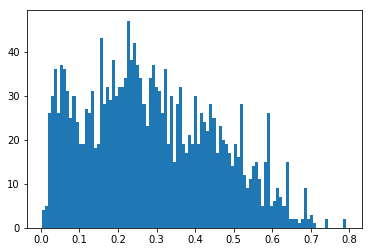

In [17]:
plt.hist([r['bleu-4'] for r in test_results], bins=100);
np.mean([r['bleu-4'] for r in test_results]), np.median([r['bleu-4'] for r in test_results])

In [18]:
dataset.set_split('val')
batch_generator = generate_nmt_batches(dataset, 
                                       batch_size=args.batch_size, 
                                       device=args.device)
batch_dict = next(batch_generator)

model = model.eval().to(args.device)
sampler = NMTSampler(vectorizer, model)
sampler.apply_to_batch(batch_dict)

In [19]:
all_results = []
for i in range(args.batch_size):
    all_results.append(sampler.get_ith_item(i, False))

In [20]:
top_results = [x for x in all_results if x['bleu-4']>0.5]
len(top_results)

3

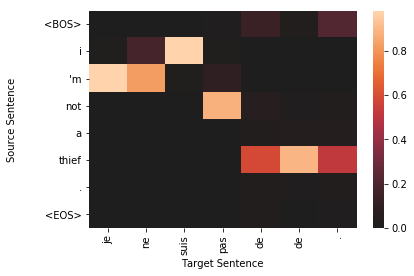

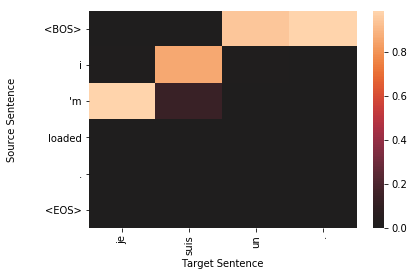

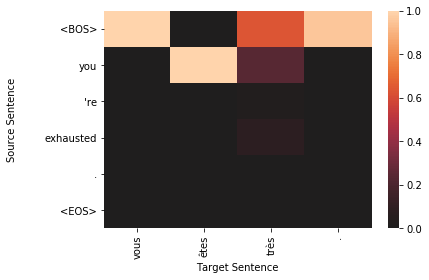

In [21]:
for sample in top_results:
    plt.figure()
    target_len = len(sample['sampled'])
    source_len = len(sample['source'])

    attention_matrix = sample['attention'][:target_len, :source_len+2].transpose()#[::-1]
    ax = sns.heatmap(attention_matrix, center=0.0)
    ylabs = ["<BOS>"]+sample['source']+["<EOS>"]
    #ylabs = sample['source']
    #ylabs = ylabs[::-1]
    ax.set_yticklabels(ylabs, rotation=0)
    ax.set_xticklabels(sample['sampled'], rotation=90)
    ax.set_xlabel("Target Sentence")
    ax.set_ylabel("Source Sentence\n\n")

In [22]:
def get_source_sentence(vectorizer, batch_dict, index):
    indices = batch_dict['x_source'][index].cpu().data.numpy()
    vocab = vectorizer.source_vocab
    return sentence_from_indices(indices, vocab)

def get_true_sentence(vectorizer, batch_dict, index):
    return sentence_from_indices(batch_dict['y_target'].cpu().data.numpy()[index], vectorizer.target_vocab)
    
def get_sampled_sentence(vectorizer, batch_dict, index):
    y_pred = model(x_source=batch_dict['x_source'], 
                   x_source_lengths=batch_dict['x_source_length'], 
                   target_sequence=batch_dict['x_target'], 
                   sample_probability=1.0)
    return sentence_from_indices(torch.max(y_pred, dim=2)[1].cpu().data.numpy()[index], vectorizer.target_vocab)

def get_all_sentences(vectorizer, batch_dict, index):
    return {"source": get_source_sentence(vectorizer, batch_dict, index), 
            "truth": get_true_sentence(vectorizer, batch_dict, index), 
            "sampled": get_sampled_sentence(vectorizer, batch_dict, index)}
    
def sentence_from_indices(indices, vocab, strict=True):
    ignore_indices = set([vocab.mask_index, vocab.begin_seq_index, vocab.end_seq_index])
    out = []
    for index in indices:
        if index == vocab.begin_seq_index and strict:
            continue
        elif index == vocab.end_seq_index and strict:
            return " ".join(out)
        else:
            out.append(vocab.lookup_index(index))
    return " ".join(out)

results = get_all_sentences(vectorizer, batch_dict, 1)
results

{'source': "you 're not as good as you think you are .",
 'truth': "vous n'êtes pas aussi bonnes que vous pensez l'être .",
 'sampled': "vous n'êtes pas très pas vous vous vous vous ?"}